# Sunspot Data

https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019?resource=download&select=sunspot_data.csv

https://datatofish.com/import-csv-file-python-using-pandas/

       Year  Month  Day  Date in Fraction of Year  Number of Sunspots  \
0      1818      1    1                  1818.001                  -1   
1      1818      1    2                  1818.004                  -1   
2      1818      1    3                  1818.007                  -1   
3      1818      1    4                  1818.010                  -1   
4      1818      1    5                  1818.012                  -1   
...     ...    ...  ...                       ...                 ...   
74778  2022      9   26                  2022.736                 134   
74779  2022      9   27                  2022.738                 109   
74780  2022      9   28                  2022.741                  86   
74781  2022      9   29                  2022.744                  72   
74782  2022      9   30                  2022.747                  76   

       Standard Deviation  Observations  Indicator  
0                    -1.0             0          1  
1                

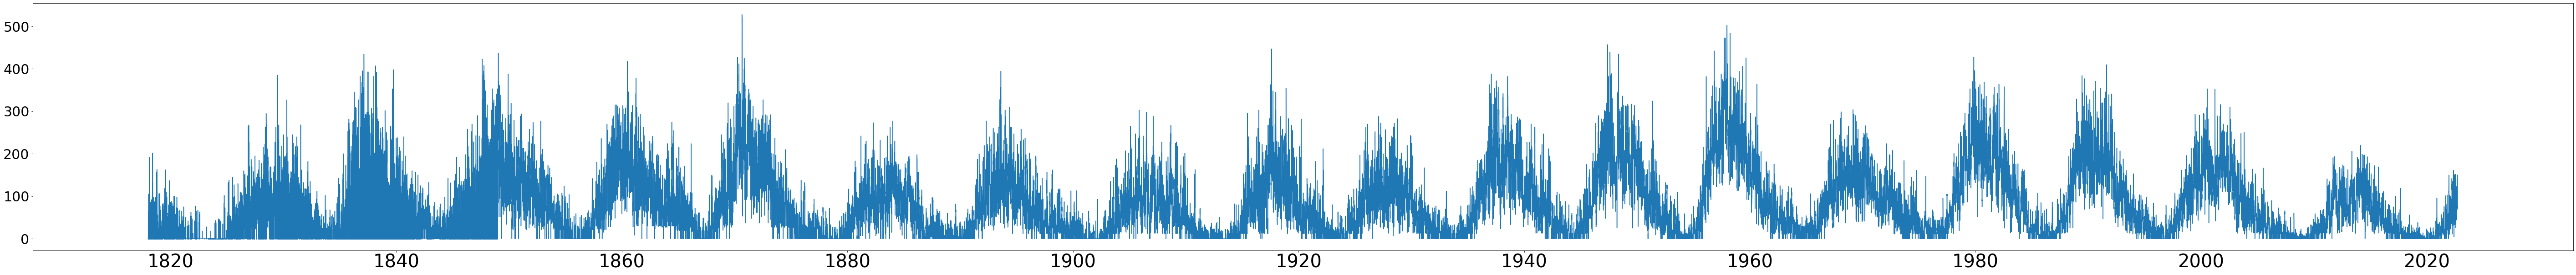

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv (r'Data/SN_d_tot_V2.0.csv', delimiter=';')
print(data)

number = pd.DataFrame(data, columns= ['Number of Sunspots'])
date = pd.DataFrame(data, columns= ['Date in Fraction of Year'])

fig = plt.figure(figsize=(100,10))
plt.plot(date, number);
plt.yticks(size=30)
plt.xticks(range(1820,2023,20),size=40)
plt.show()